# Death to Cluster Models; Long Live Context Encoders
Outline:
- Regression: population vs. cluster vs. context-specific models (compared on MSE and L2)
- Networks: population vs. cluster vs. context-specific models (compared on L2)

We don't see all values of context but with a context encoder we can fill in the gaps rather than referring to the nearest cluster. This is important because gaps often represent:

- Undersampled / underrepresented patient populations
- Undocumented / undiscovered treatments
- Rare cell types / diseases / risk factors

In [1]:
import numpy as np
import torch

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

In [2]:
n_z = 75
Z_space = np.linspace(-1, 1, n_z)
Z = np.zeros((n_z**2, 2))
for i, z_i in enumerate(Z_space):
    for j, z_j in enumerate(Z_space):
        Z[i * n_z + j] = [z_i, z_j]
z_samples = 1
Z_labels = np.repeat(Z, z_samples, axis=0)
C = Z_labels.copy()
C = C[::-1]

W = np.zeros_like(Z_labels)
W[:,0] = C[:,0] + C[:,1]**2 
W[:,1] = C[:,0]**2 + C[:,1] 
W = np.repeat(W, z_samples, axis=0)
# W += np.random.normal(0, .1, W.shape)
X = np.random.uniform(-1, 1, W.shape)
Y = (X * W).sum(axis=1)[:, np.newaxis]
Y += np.random.normal(0, .1, Y.shape)

def get_idx(Z):
    dist = lambda a, b: np.sqrt(np.sum((a - b)**2)) 
    gap_centers = np.array([
        [0, 0],
        [.5, .5],
        [.5, -.5],
        [-.5, .5],
        [-.5, -.5],
    ])
    gap_radius = .1
    gap_idx = np.ones(len(Z))
    for i, z in enumerate(Z):
        for gap_center in gap_centers:
            if dist(z, gap_center) < gap_radius:
                gap_idx[i] = 0
    return gap_idx
    
    
gap_idx = get_idx(Z_labels)
train_idx, test_idx = gap_idx == 0, gap_idx == 1
split = lambda arr: (arr[train_idx], arr[test_idx])
Z_train, Z_test = split(Z_labels)
C_train_pre, C_test_pre = split(C)
C_mean, C_std = C_train_pre.mean(axis=0), C_train_pre.std(axis=0)
C_train = (C_train_pre - C_mean) / C_std
C_test = (C_test_pre - C_mean) / C_std
W_train, W_test = split(W)
X_train, X_test = split(X)
Y_train, Y_test = split(Y)

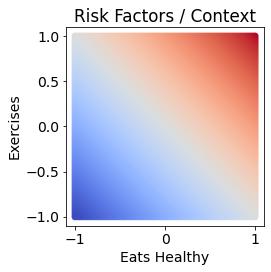

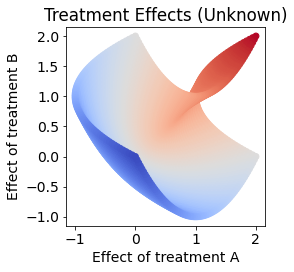

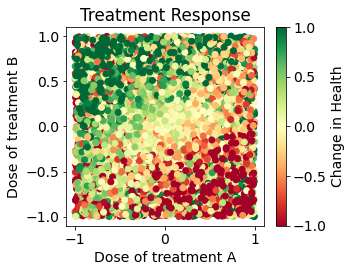

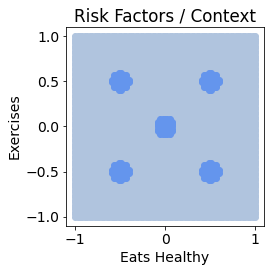

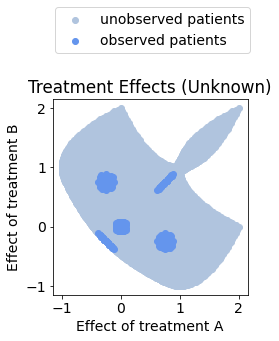

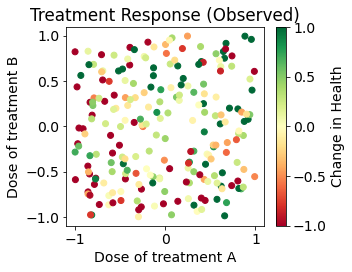

In [3]:
# Preliminary Exploration and Plotting
def cbar(arr):
    c = (arr - arr.mean()) / arr.std()
    return c

# Plot the context and treatment effect spaces
plt.figure(figsize=(4,4))
plt.scatter(C[:,0], C[:,1], c=C[:,0]+C[:,1], cmap='coolwarm')
plt.xlabel('Eats Healthy')
plt.ylabel('Exercises')
plt.title('Risk Factors / Context')
plt.tight_layout()
# plt.savefig('figures/all_riskfactors.png', dpi=300)
plt.show()

plt.figure(figsize=(4,4))
plt.scatter(W[:,0], W[:,1], c=C[:,0]+C[:,1], cmap='coolwarm')
plt.xlabel('Effect of treatment A')
plt.ylabel('Effect of treatment B')
plt.title('Treatment Effects (Unknown)')
plt.tight_layout()
# plt.savefig('figures/all_trueeffects.png', dpi=300)
plt.show()

# Plot the treatment response
plt.figure(figsize=(5.05,4))
plt.scatter(X[:,0], X[:,1], c=cbar(Y), cmap='RdYlGn')
plt.xlabel('Dose of treatment A')
plt.ylabel('Dose of treatment B')
plt.colorbar(label='Change in Health')
plt.clim(-1, 1)
plt.title('Treatment Response')
plt.tight_layout()
# plt.savefig('figures/all_responses.png', dpi=300)
plt.show()

# Plot the context and treatment effects for observed patients
plt.figure(figsize=(4,4))
plt.scatter(C_test_pre[:,0], C_test_pre[:,1], c='lightsteelblue', label='unobserved patients')
plt.scatter(C_train_pre[:,0], C_train_pre[:,1], c='cornflowerblue', label='observed patients')
plt.xlabel('Eats Healthy')
plt.ylabel('Exercises')
plt.title('Risk Factors / Context')
plt.tight_layout()
# plt.savefig('figures/train_riskfactors.png', dpi=300)
plt.show()

plt.figure(figsize=(4,5.2))
plt.scatter(W_test[:,0], W_test[:,1], c='lightsteelblue', label='unobserved patients')
plt.scatter(W_train[:,0], W_train[:,1], c='cornflowerblue', label='observed patients')
plt.xlabel('Effect of treatment A')
plt.ylabel('Effect of treatment B')
plt.title('Treatment Effects (Unknown)')
plt.legend(bbox_to_anchor=(1.05, 1.2), loc='lower right')
plt.tight_layout()
# plt.savefig('figures/train_trueeffects.png', dpi=300)
plt.show()

# Plot the treatment response for observed patients
plt.figure(figsize=(5.05,4))
plt.scatter(X_train[:,0], X_train[:,1], c=cbar(Y_train), cmap='RdYlGn')
plt.xlabel('Dose of treatment A')
plt.ylabel('Dose of treatment B')
plt.colorbar(label='Change in Health')
plt.clim(-1, 1)
plt.title('Treatment Response (Observed)')
plt.tight_layout()
# plt.savefig('figures/train_responses.png', dpi=300)
plt.show()

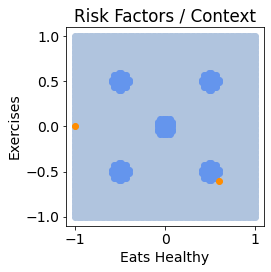

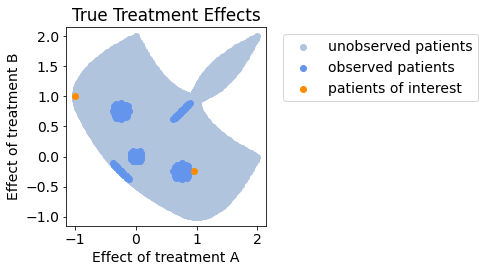

In [4]:
# Identify patients of interest
C_patients_pre = np.array([
    [.6, -.6],
    [-1, 0]
])
W_patients = np.zeros_like(C_patients_pre)
W_patients[:,0] = C_patients_pre[:,0] + C_patients_pre[:,1]**2 
W_patients[:,1] = C_patients_pre[:,0]**2 + C_patients_pre[:,1] 

C_patients = (C_patients_pre - C_mean) / C_std
X_patients = np.zeros_like(W_patients)
Y_patients = np.zeros((len(X_patients), 1))

plt.figure(figsize=(4,4))
plt.scatter(C_test_pre[:,0], C_test_pre[:,1], c='lightsteelblue', label='unobserved')
plt.scatter(C_train_pre[:,0], C_train_pre[:,1], c='cornflowerblue', label='observed')
plt.scatter(C_patients_pre[:,0], C_patients_pre[:,1], c='darkorange', label='patients of interest')
plt.xlabel('Eats Healthy')
plt.ylabel('Exercises')
plt.title('Risk Factors / Context')
plt.tight_layout()
# plt.savefig('figures/patient_riskfactors.png', dpi=300)
plt.show()

plt.figure(figsize=(7.1,4))
plt.scatter(W_test[:,0], W_test[:,1], c='lightsteelblue', label='unobserved patients')
plt.scatter(W_train[:,0], W_train[:,1], c='cornflowerblue', label='observed patients')
plt.scatter(W_patients[:,0], W_patients[:,1], c='darkorange', label='patients of interest')
plt.xlabel('Effect of treatment A')
plt.ylabel('Effect of treatment B')
plt.title('True Treatment Effects')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
# plt.savefig('figures/patient_trueeffects.png', dpi=300)
plt.show()

In [5]:
# Pre-define our result plots
def plot_all(w_hat, patient_w_hat, model_name):
    fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 4))
    axs[0].scatter(W_test[:,0], W_test[:,1], c='lightsteelblue')
    axs[0].scatter(W_train[:,0], W_train[:,1], c='cornflowerblue')
    axs[0].scatter(w_hat[:,0], w_hat[:,1], c='crimson', label='predicted effects (all unobserved)')

    axs[1].scatter(W_test[:,0], W_test[:,1], c='lightsteelblue', label='true effects (unobserved patients)')
    axs[1].scatter(W_train[:,0], W_train[:,1], c='cornflowerblue', label='true effects (observed patients)')
    axs[1].scatter([], [], c='crimson', label='predicted effects (unobserved patients)')  # dummy plot for legend
    axs[1].scatter(W_patients[:,0], W_patients[:,1], c='darkorange', label='true effects (patients of interest)')
    axs[1].scatter(patient_w_hat[:,0], patient_w_hat[:,1], c='gold', label='predicted effects (patients of interest)')
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    fig.add_subplot(111, frameon=False)  # subplot axis hack
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    plt.xlabel('Effect of treatment A')
    plt.ylabel('Effect of treatment B')
    plt.title('Treatment Effects')
    plt.tight_layout()
    plt.savefig(f'figures/{model_name}_effects.png', dpi=300)
    plt.show()

In [6]:
# Models
from sklearn.cluster import KMeans
mse = lambda true, pred: ((true - pred)**2).mean()


class NaiveRegression:
    def __init__(self):
        pass
    
    def fit(self, X, Y):
        self.w = np.linalg.inv(X.T @ X) @ X.T @ Y
        return self
        
    def predict_w(self, X):
        return np.tile(self.w.T, (len(X), 1))
    
    def predict_y(self, X):
        w_hat = self.predict_w(X)
        y_hat = (X * w_hat).sum(axis=1)[:, np.newaxis]
        return y_hat


class ClusterRegression:
    def __init__(self, K):
        self.K = K
        self.kmeans = KMeans(n_clusters=K)
        self.models = {k: NaiveRegression() for k in range(K)}
    
    def fit(self, C, X, Y):
        self.wdim = X.shape[-1]
        self.kmeans.fit(C)
        for k in range(self.K):
            k_idx = self.kmeans.labels_ == k
            X_k, Y_k = X[k_idx], Y[k_idx]
            self.models[k].fit(X_k, Y_k)
        return self
            
    def predict_l(self, C):
        return self.kmeans.predict(C)
    
    def predict_w(self, C, X):
        labels = self.predict_l(C)
        w_hat = np.zeros_like(X)
        for label in np.unique(labels):
            l_idx = labels == label
            X_l = X[l_idx]
            w_hat[l_idx] = self.models[label].predict_w(X_l)
        return w_hat
    
    def predict_y(self, C, X):
        labels = self.predict_l(C)
        y_hat = np.zeros((len(X), 1))
        for label in np.unique(labels):
            l_idx = labels == label
            X_l = X[l_idx]
            y_hat[l_idx] = self.models[label].predict_y(X_l)
        return y_hat

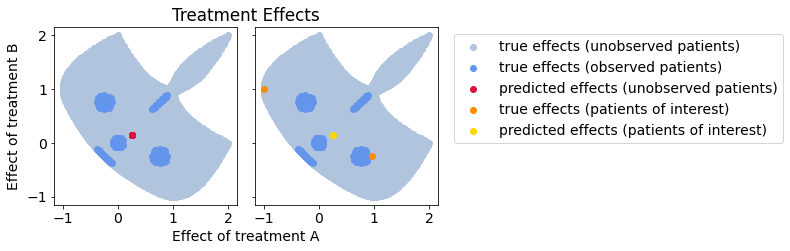

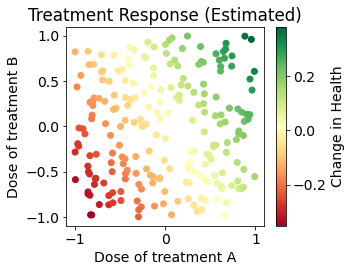

Treatment-response error: 	0.3272393894866383
Effect-size error: 		0.4689377107795835


In [8]:
# Population regression
naive_model = NaiveRegression().fit(X_train, Y_train)

w_hat = naive_model.predict_w(X_test)
patient_w_hat = naive_model.predict_w(X_patients)
y_hat = naive_model.predict_y(X_test)

plot_all(w_hat, patient_w_hat, 'population')

plt.figure(figsize=(5.05,4))
plt.scatter(X_train[:,0], X_train[:,1], c=naive_model.predict_y(X_train), cmap='RdYlGn')
plt.xlabel('Dose of treatment A')
plt.ylabel('Dose of treatment B')
plt.colorbar(label='Change in Health')
plt.title('Treatment Response (Estimated)')
plt.tight_layout()
# plt.savefig('figures/population_responses.png', dpi=300)
plt.show()

y_mse = mse(Y_test, y_hat)
w_mse = mse(W_test, w_hat)
print(f"Treatment-response error: \t{y_mse}")
print(f"Effect-size error: \t\t{w_mse}")

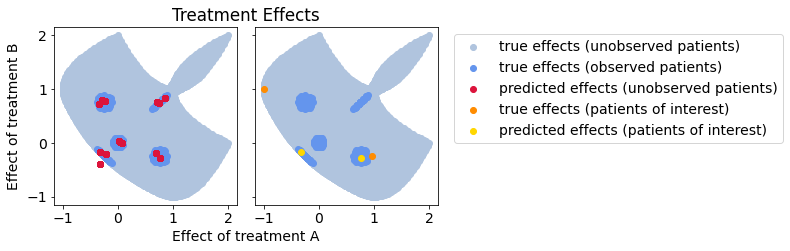

Treatment-response error: 	0.12051654668177877
Effect-size error: 		0.16128946160959065


In [9]:
# Cluster regression
cluster_model = ClusterRegression(15).fit(C_train, X_train, Y_train)
w_hat = cluster_model.predict_w(C_test, X_test)
y_hat = cluster_model.predict_y(C_test, X_test)
patient_w_hat = cluster_model.predict_w(C_patients, X_patients)

plot_all(w_hat, patient_w_hat, 'cluster_neat')

y_mse = mse(Y_test, y_hat)
w_mse = mse(W_test, w_hat)
print(f"Treatment-response error: \t{y_mse}")
print(f"Effect-size error: \t\t{w_mse}")

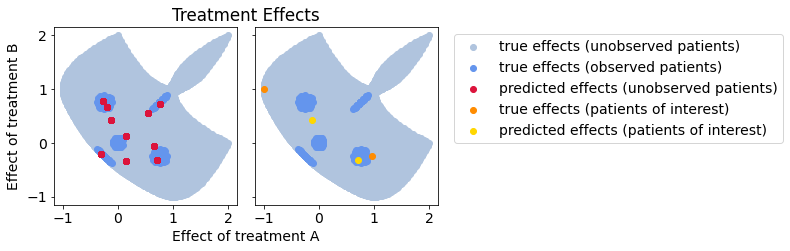

Response error: 0.1618164890678853
Effect-size error: 0.22065583467368283


In [10]:
# Regression from noise-context clustering
noise = np.random.normal(0, 1, (len(C), 2))
noise_train, noise_test = split(noise)
noise_mean, noise_std = noise_train.mean(axis=0), noise_train.std(axis=0)
noise_train = (noise_train - noise_mean) / noise_std
noise_test = (noise_test - noise_mean) / noise_std
C_noise_train = np.concatenate((C_train, noise_train), axis=-1)
C_noise_test = np.concatenate((C_test, noise_test), axis=-1)
C_noise_patients = np.concatenate((C_patients, noise_test[:len(C_patients)]), axis=-1)

cluster_model = ClusterRegression(10).fit(C_noise_train, X_train, Y_train)
w_hat = cluster_model.predict_w(C_noise_test, X_test)
y_hat = cluster_model.predict_y(C_noise_test, X_test)
patient_w_hat = cluster_model.predict_w(C_noise_patients, X_patients)

plot_all(w_hat, patient_w_hat, 'cluster_noisy')

y_mse = mse(Y_test, y_hat)
w_mse = mse(W_test, w_hat)
print(f"Response error: {y_mse}")
print(f"Effect-size error: {w_mse}")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/Caskroom/miniconda/base/envs/correlator/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")

  | Name      | Type             | Params
-----------------------------------------------
0 | metamodel | SubtypeMetamodel | 1.1 K 
-----------------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)
/usr/local/Caskroom/miniconda/base/envs/correlator/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing

Training: 0it [00:00, ?it/s]

/usr/local/Caskroom/miniconda/base/envs/correlator/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 221it [00:00, ?it/s]

Predicting: 221it [00:00, ?it/s]

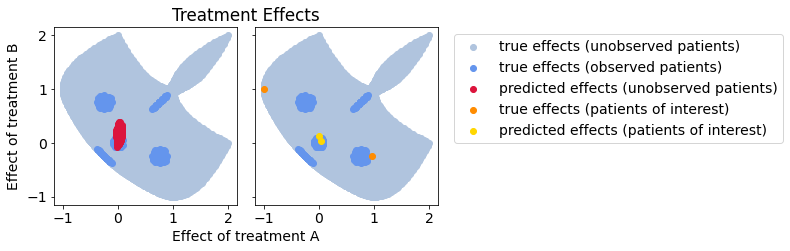

Response error: 0.3629922910075171
Effect-size error: 0.5264720697693606


In [25]:
from contextualized.regression import ContextualizedRegression, RegressionTrainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

# Regression from noise encoding
encoder_kwargs = {'width': 50, 'layers': 2}
model = ContextualizedRegression(noise.shape[-1], X.shape[-1], Y.shape[-1], encoder_kwargs=encoder_kwargs)
train_dataloader = model.dataloader(noise_train, X_train, Y_train, batch_size=1)
test_dataloader = model.dataloader(noise_test, X_test, Y_test, batch_size=100)
patient_dataloader = model.dataloader(noise_test[:len(C_patients)], X_patients, Y_patients, batch_size=1)
trainer = RegressionTrainer(max_epochs=2, auto_lr_find=True)
trainer.fit(model, train_dataloader)

w_hat, _ = trainer.predict_params(model, test_dataloader)
w_hat = w_hat.squeeze()
y_hat = (X_test * w_hat).sum(axis=1)[:,np.newaxis]

patient_w_hat, _ = trainer.predict_params(model, patient_dataloader)
patient_w_hat = patient_w_hat.squeeze()

plot_all(w_hat, patient_w_hat, 'encoder_noise')

y_mse = mse(Y_test, y_hat)
w_mse = mse(W_test, w_hat)
print(f"Response error: {y_mse}")
print(f"Effect-size error: {w_mse}")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name      | Type             | Params
-----------------------------------------------
0 | metamodel | SubtypeMetamodel | 365   
-----------------------------------------------
365       Trainable params
0         Non-trainable params
365       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Predicting: 221it [00:00, ?it/s]

Predicting: 221it [00:00, ?it/s]

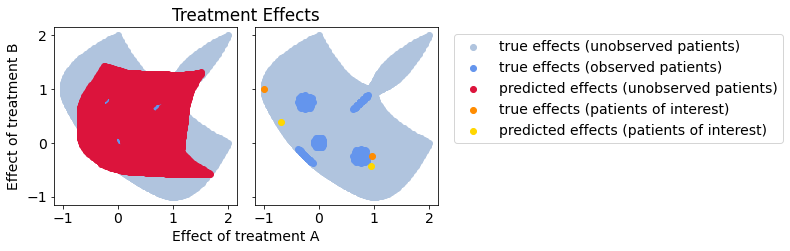

Response error: 0.04998703318889118
Effect-size error: 0.05985841090970689


In [80]:
# Regression from context encoding
encoder_kwargs = {'width': 25, 'layers': 2}
model = ContextualizedRegression(C.shape[-1], X.shape[-1], Y.shape[-1], encoder_kwargs=encoder_kwargs)
train_dataloader = model.dataloader(C_train, X_train, Y_train, batch_size=1)
test_dataloader = model.dataloader(C_test, X_test, Y_test, batch_size=100)
patient_dataloader = model.dataloader(C_patients, X_patients, Y_patients, batch_size=1)

trainer = RegressionTrainer(max_epochs=50, auto_lr_find=True)
trainer.fit(model, train_dataloader)

w_hat, _ = trainer.predict_params(model, test_dataloader)
w_hat = w_hat.squeeze()
y_hat = (X_test * w_hat).sum(axis=1)[:,np.newaxis]

patient_w_hat, _ = trainer.predict_params(model, patient_dataloader)
patient_w_hat = patient_w_hat.squeeze()

plot_all(w_hat, patient_w_hat, 'encoder')

y_mse = mse(Y_test, y_hat)
w_mse = mse(W_test, w_hat)
print(f"Response error: {y_mse}")
print(f"Effect-size error: {w_mse}")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name      | Type             | Params
-----------------------------------------------
0 | metamodel | SubtypeMetamodel | 790   
-----------------------------------------------
790       Trainable params
0         Non-trainable params
790       Total params
0.003     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Predicting: 221it [00:00, ?it/s]

Predicting: 221it [00:00, ?it/s]

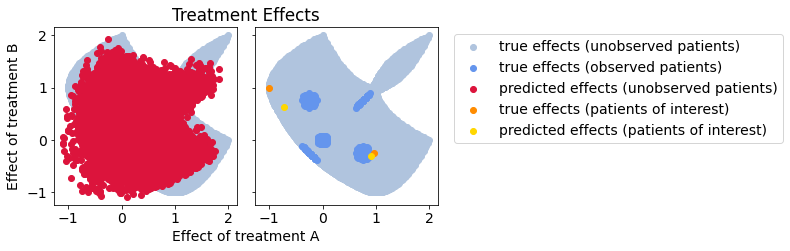

Response error: 0.045323492193908466
Effect-size error: 0.05233014554967325


In [67]:
# Regression from noisy context encoding
encoder_kwargs = {'width': 50, 'layers': 2}
model = ContextualizedRegression(C_noise_train.shape[-1], X.shape[-1], Y.shape[-1], encoder_kwargs=encoder_kwargs)
train_dataloader = model.dataloader(C_noise_train, X_train, Y_train, batch_size=1)
test_dataloader = model.dataloader(C_noise_test, X_test, Y_test, batch_size=100)
patient_dataloader = model.dataloader(C_noise_patients, X_patients, Y_patients, batch_size=1)

trainer = RegressionTrainer(max_epochs=200, auto_lr_find=True)
trainer.fit(model, train_dataloader)

w_hat, _ = trainer.predict_params(model, test_dataloader)
w_hat = w_hat.squeeze()
y_hat = (X_test * w_hat).sum(axis=1)[:,np.newaxis]

patient_w_hat, _ = trainer.predict_params(model, patient_dataloader)
patient_w_hat = patient_w_hat.squeeze()

plot_all(w_hat, patient_w_hat, 'encoder_somenoise')

y_mse = mse(Y_test, y_hat)
w_mse = mse(W_test, w_hat)
print(f"Response error: {y_mse}")
print(f"Effect-size error: {w_mse}")

/var/folders/_6/468mk1cx3cb080z2r5gq0k_r0000gn/T/ipykernel_42617/2174021007.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_train = torch.tensor(Y_train, dtype=torch.float32)
/var/folders/_6/468mk1cx3cb080z2r5gq0k_r0000gn/T/ipykernel_42617/2174021007.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_test = torch.tensor(Y_test, dtype=torch.float32)
/var/folders/_6/468mk1cx3cb080z2r5gq0k_r0000gn/T/ipykernel_42617/2174021007.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_patients = torch.tensor(Y_patients, dtype=torch.flo

tensor(0.1981, grad_fn=<MeanBackward0>)
tensor(0.0085, grad_fn=<MeanBackward0>)
tensor(0.0898, grad_fn=<MeanBackward0>)


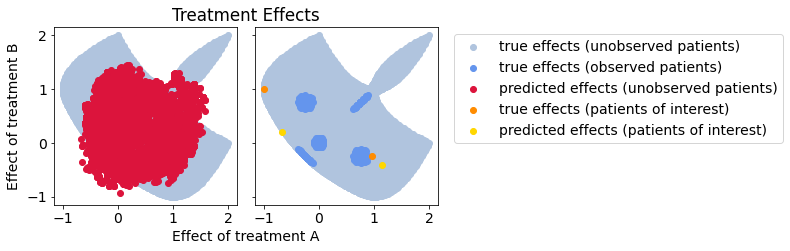

Response error: 0.08976248651742935
Effect-size error: 0.13434243202209473


In [140]:
# gradient models from MLP(CX) -> Y
from contextualized.modules import MLP

def get_grad(model, X):
    X.requires_grad = True
    for i in range(len(X)):
        yhat = model(X)
        yhat[i].backward()
    w_hat = X.grad.clone()
    X.requires_grad = False
    return w_hat

CX = torch.tensor(np.concatenate((C, X), axis=-1), dtype=torch.float32)
CX_patients = torch.tensor(np.concatenate((C_patients, X_patients), axis=-1), dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.float32)
Y_patients = torch.tensor(Y_patients, dtype=torch.float32)

CX_train, CX_test = split(CX)
mlp = MLP(CX.shape[-1], Y.shape[-1], 50, 2)
print(mse(mlp(CX_train), Y_train))
opt = torch.optim.Adam(mlp.parameters(), lr=1e-3)
for _ in range(1000):
    loss = mse(mlp(CX_train), Y_train)
    opt.zero_grad()
    loss.backward()
    opt.step()
print(mse(mlp(CX_train), Y_train))
print(mse(mlp(CX_test), Y_test))
train_w_hat_train = get_grad(mlp, CX_train)[:,-X.shape[-1]:]
test_w_hat = get_grad(mlp, CX_test)[:,-X.shape[-1]:]
patient_w_hat = get_grad(mlp, CX_patients)[:,-X_patients.shape[-1]:]
plot_all(test_w_hat, patient_w_hat, 'cx_mlp')

y_mse = mse(Y_test, mlp(CX_test))
w_mse = mse(torch.tensor(W_test, dtype=torch.float32), test_w_hat)
print(f"Response error: {y_mse}")
print(f"Effect-size error: {w_mse}")

# Networks
- Bayesian networks: y = w(c) * x + eps
- Correlation networks: y = w(c) * x + eps(C)

In [142]:
import tensorflow as tf

# import contextualized
# import importlib
# importlib.reload(contextualized)
# NOTMAD = contextualized.notmad.NOTMAD
# NOTEARS = contextualized.notmad_helpers.baselines.NOTEARS
# ClusteredNOTEARS = contextualized.notmad_helpers.baselines.ClusteredNOTEARS
# graph_utils = contextualized.notmad_helpers.graph_utils

from contextualized.notmad import NOTMAD
from contextualized.notmad_helpers.baselines import NOTEARS, ClusteredNOTEARS
from contextualized.notmad_helpers import graph_utils, simulation

In [229]:
n = 1000
C = np.linspace(1, 2, n).reshape((n, 1))
# C = np.ones((n, 1))
blank = np.zeros_like(C)
W_00 = blank
W_01 = C-2
# W_01 = np.ones_like(C)
W_02 = blank
W_03 = blank
W_10 = blank
W_11 = blank
W_12 = blank
W_13 = blank
W_20 = blank
W_21 = C**2
W_22 = blank
W_23 = blank
W_30 = blank
W_31 = C**3
W_32 = C
W_33 = blank
W = np.array([
    [W_00, W_01, W_02, W_03],
    [W_10, W_11, W_12, W_13],
    [W_20, W_21, W_22, W_23],
    [W_30, W_31, W_32, W_33],
]).squeeze()
W = np.transpose(W, (2, 0, 1))

dag_pred = lambda x, w: tf.matmul(x, w).numpy().squeeze()
X_pre = np.random.uniform(-1, 1, (n, 4))
# eps = np.random.normal(0, .1, (n, 4))
X = np.zeros_like(X_pre)
for i, (w, X_p) in enumerate(zip(W, X_pre)):
    eps = np.random.normal(0, .01, 4)
    X_new = dag_pred(X_p[np.newaxis, :], w)
    X[i] = X_new + eps

idx = np.logical_and(C > 1.7, C < 1.9).squeeze()
# idx = np.arange(0, n) < n//10
# idx = np.arange
test_idx = np.argwhere(idx).squeeze()
train_idx = np.argwhere(~idx).squeeze()
split = lambda arr: (arr[train_idx], arr[test_idx])
W_train, W_test = split(W)
C_train, C_test = split(C)
X_train, X_test = split(X)
C_train.shape, C_test.shape

((800, 1), (200, 1))

In [230]:
# Population Model
loss_params = {'l1': 0., 'init_alpha': 1e-1, 'init_rho': 1e-2}

notears = NOTEARS(loss_params, C_train.shape, W_train.shape[1:])
notears.fit(C_train, X_train, epochs=15, batch_size=100)

naive_preds_train = notears.predict_w(C_train, project_to_dag=True).squeeze()
naive_preds = notears.predict_w(C_test, project_to_dag=True).squeeze()
print(f"train l2:  {mse(naive_preds_train, W_train)}")
print(f"test l2:   {mse(naive_preds, W_test)}")
print(f"train mse: {mse(dag_pred(X_train, naive_preds_train), X_train)}")
print(f"test mse:  {mse(dag_pred(X_test, naive_preds), X_test)}")

NOTEARS Training:   0%|                                 0/15 ETA: ?s,  ?epochs/s

train l2:  1.3392408496556079
test l2:   3.002955961755524
train mse: 2.0251307794984443
test mse:  3.734721444482127


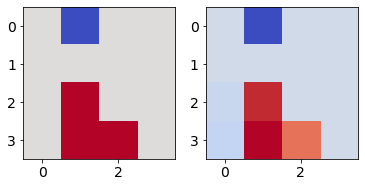

In [231]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(W_train[0], cmap='coolwarm')
axs[1].imshow(naive_preds_train[0], cmap='coolwarm')

In [232]:
# Cluster Model
clustered_notears = ClusteredNOTEARS(
    15, loss_params, C_train.shape, W_train.shape[1:]
)
clustered_notears.fit(C_train, X_train, epochs=15, batch_size=100)

clustered_preds_train = clustered_notears.predict_w(C_train, project_to_dag=True).squeeze()
clustered_preds = clustered_notears.predict_w(C_test, project_to_dag=True).squeeze()
print(f"train l2: {mse(clustered_preds_train, W_train)}")
print(f"test l2:  {mse(clustered_preds, W_test)}")
print(f"train mse: {mse(dag_pred(X_train, clustered_preds_train), X_train)}")
print(f"test mse:  {mse(dag_pred(X_test, clustered_preds), X_test)}")


Clustered NOTEARS Training: 100%|███████████████| 15/15 [00:36<00:00,  2.46s/it]

train l2: 1.3504188504146264
test l2:  3.0130219304970525
train mse: 2.0316613112313195
test mse:  3.7467562631996456


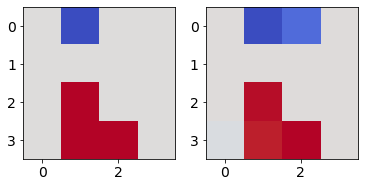

In [233]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(W_train[0], cmap='coolwarm')
axs[1].imshow(clustered_preds_train[0], cmap='coolwarm')

In [234]:
def fit_notmad(sample_specific_loss_params, archetype_loss_params, 
                  C_train, X_train, k, project, notears_pop, base_predictor):
    init_mat = np.random.uniform(-0.01, 0.01, size=(k, X_train.shape[-1], X_train.shape[-1])) #np.zeros((k, X_train.shape[-1], X_train.shape[-1])) #
    make_notmad = lambda: NOTMAD(
        C_train.shape, X_train.shape, k,
        sample_specific_loss_params, archetype_loss_params,
        n_encoder_layers=2, encoder_width=32,
        activation='linear', init_mat=init_mat,
        learning_rate=1e-3, project_archs_to_dag=project, # TODO: should this be variable?
        project_distance=1.0,
        context_activity_regularizer=tf.keras.regularizers.l1(0),
        use_compatibility=False, update_compat_by_grad=False,
        pop_model=None, base_predictor=base_predictor
    )
    notmad = make_notmad()
    notmad.fit(
        C_train, X_train, batch_size=1, epochs=100, 
        es_patience=2, verbose=1
    )
    return notmad

k = 5
loss_params = {'l1': 0., 'init_alpha': 1e-1, 'init_rho': 1e-2}
# loss_params = {'l1': 1e-2, 'alpha': 1e-1, 'rho': 1e-2}
archetype_loss_params = {'l1': 0., 'alpha': 1e-1, 'rho': 1e-2}
notmad = fit_notmad(
    loss_params, archetype_loss_params,
    C_train, X_train, k, project=True, 
    notears_pop=None, base_predictor=notears
)

# estimating transposed networks?
notmad_preds_train = notmad.predict_w(C_train, project_to_dag=True).squeeze()
notmad_preds = notmad.predict_w(C_test, project_to_dag=True).squeeze()
print(f"train l2: {mse(notmad_preds_train, W_train)}")
print(f"test l2:  {mse(notmad_preds, W_test)}")
print(f"train mse: {mse(dag_pred(X_train, notmad_preds_train), X_train)}")
print(f"test mse:  {mse(dag_pred(X_test, notmad_preds), X_test)}")

NOTMAD Training:   0%|                                 0/100 ETA: ?s,  ?epochs/s

train l2: 0.7719928029779703
test l2:  1.9992385853726558
train mse: 1.0048683385975408
test mse:  1.5268425884671177


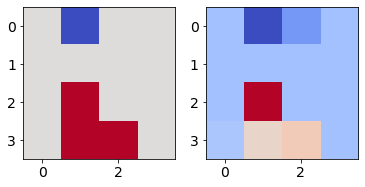

In [235]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(W_train[0], cmap='coolwarm')
axs[1].imshow(notmad_preds_train[0], cmap='coolwarm')

## Correlation nets

In [11]:
from contextualized.networks import ContextualizedCorrelation, NetworkTrainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

Global correlation: [[0.917758]]


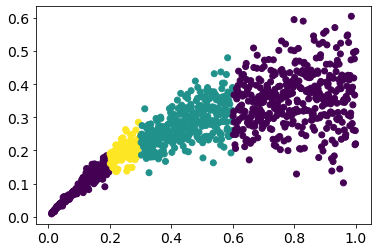

In [14]:
n = 1000
C = np.linspace(.01, 1, n).reshape((n, 1))
w = np.exp(-C)
# w = np.ones_like(C)
X = np.linspace(.01, 1, n).reshape((n, 1))
eps = np.random.normal(0, .1*C, (n, 1))
Y = X * w + eps
V = np.concatenate((X, Y), axis=-1)

val_idx = np.logical_and(.2 <= C, C < .3).squeeze()
test_idx = np.logical_and(.3 <= C, C < .6).squeeze()
train_idx = np.logical_or(C < .2, .6 <= C).squeeze()
idx = np.zeros(n)
idx[test_idx] = 1
idx[val_idx] = 2
split = lambda arr: (arr[train_idx], arr[test_idx], arr[val_idx])
C_train, C_test, C_val = split(C)
X_train, X_test, X_val = split(X)
Y_train, Y_test, Y_val = split(Y)
V_train, V_test, V_val = split(V)

w_xy = np.linalg.inv(X.T @ X) @ X.T @ Y
w_yx = np.linalg.inv(Y.T @ Y) @ Y.T @ X
print(f'Global correlation: {w_xy * w_yx}')

plt.scatter(X, Y, c=idx)
plt.show()

In [25]:
# link_fn = lambda x: torch.nn.functional.softmax(x, dim=1)
model = ContextualizedCorrelation(C.shape[-1], V.shape[-1])
train_dataset = model.dataloader(C_train, V_train, batch_size=1)
test_dataset = model.dataloader(C_test, V_test, batch_size=10)
val_dataset = model.dataloader(C_val, V_val, batch_size=10)
trainer = NetworkTrainer(
    max_epochs=100, 
    auto_lr_find=True, 
    check_val_every_n_epoch=5,  # number of epochs between validation checks
    val_check_interval=5,  # number of times to check validation per epoch when validating
    callbacks=[EarlyStopping(monitor="val_loss", mode="min", patience=5)]  # Early stopping on <patience> val_loss increases
)
trainer.fit(model, train_dataset, val_dataset)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name      | Type             | Params
-----------------------------------------------
0 | metamodel | SubtypeMetamodel | 390   
-----------------------------------------------
390       Trainable params
0         Non-trainable params
390       Total params
0.002     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Predicting: 35it [00:00, ?it/s]

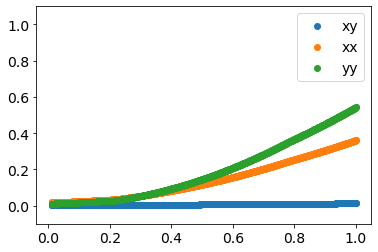

In [26]:
dataset = model.dataloader(C, V, batch_size=10)
corrs = trainer.predict_network(model, dataset)
# plt.scatter(C.squeeze(), corrs[:,1,0]/(.5 * corrs[:,0,0] + .5 * corrs[:,1,1]) , label='xy')
# plt.scatter(C.squeeze(), corrs[:,0,0]/corrs[:,0,0], label='xx')
# plt.scatter(C.squeeze(), corrs[:,1,1]/corrs[:,1,1], label='yy')
plt.scatter(C.squeeze(), corrs[:,1,0], label='xy')
plt.scatter(C.squeeze(), corrs[:,0,0], label='xx')
plt.scatter(C.squeeze(), corrs[:,1,1], label='yy')
plt.ylim(-.1, 1.1)
plt.legend()
plt.show()

In [27]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/

Reusing TensorBoard on port 6006 (pid 22137), started 0:13:04 ago. (Use '!kill 22137' to kill it.)

### Learning Check

In [262]:
betas, mus = trainer.predict_params(model, test_dataset)
betas.shape, mus.shape, X_test.shape, Y_test.shape

Predicting: 697it [00:00, ?it/s]

((303, 2, 2), (303, 2, 2), (303, 1), (303, 1))

In [263]:
y_hat = betas[:,1,0] * X_test[:,0] + mus[:,0,1]
y_hat_sans = betas[:,1,0] * X_test[:,0]
residual = ((Y_test[:,0] - y_hat)**2).mean()
residual_sans_mu = ((Y_test[:,0] - y_hat_sans)**2).mean()
residual_sans_beta = ((Y_test[:,0] - mus[:,1,0])**2).mean()
residual, residual_sans_mu, residual_sans_beta

(0.003118000308677679, 0.04327022708763347, 0.05872566233334667)